----
# Cleanup And EDA

In [330]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

In [331]:
# Load patients data
df = pd.read_csv('../../data/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [332]:
# Check the rows and columns
df.shape

(54706, 14)

----
## Cleaning

In [333]:
# Check null values
df.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [334]:
# Train only columns
targets = ['cancer', 'biopsy', 'invasive', 'BIRADS', 'difficult_negative_case']
df[targets]

,cancer,biopsy,invasive,BIRADS,difficult_negative_case
0,0,0,0,NaN,False
1,0,0,0,NaN,False
2,0,0,0,NaN,False
3,0,0,0,NaN,False
4,0,0,0,0.0,True
...,...,...,...,...,...
54701,0,0,0,1.0,False
54702,0,0,0,NaN,False
54703,0,0,0,NaN,False
54704,0,0,0,0.0,True


----
- Dropping machine_id column since it has half of the records we have and it might be useful for EDA to find out about which machine getting it correct
- Dropping age column missing values since its only 37 records and using imputer may skew the analysis result
  

In [335]:
# Drop rows with nan on age 
df = df[df['age'].notna()]

# Drop machine_id column
df.drop(columns='machine_id', inplace=True)

- BIRADS:
  - 0 if the breast required follow-up, 
  - 1 if the breast was rated as negative for cancer, and 
  - 2 if the breast was rated as normal. Only provided for train.

In [336]:
def populate_birads(row):
  """Produce BIRADS based on conditions

  Args:
      row (dataframe): Pandas dataframe

  Returns:
      int: Produced BIRADS
  """
  # If patient has no cancer and was not difficult negative case than return 2
  if row['cancer'] == 0 and pd.isnull(row['BIRADS']) and row['difficult_negative_case'] == False:
    return 2
  # If patient has cancer and it was difficult negative case than return 0
  elif pd.isnull(row['BIRADS']) and (row['difficult_negative_case'] or row['cancer'] == 1):
    return 0
  # Else return 1
  elif pd.isnull(row['BIRADS']):
    return 1
  
  # Return BIRADS original value
  return int(row['BIRADS'])

In [337]:
# Assign BIRADS
df['BIRADS'] = df.loc[:, df.columns].apply(lambda row: populate_birads(row), axis=1)

In [338]:
# Check if any nans left
df.isna().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                            0
cancer                         0
biopsy                         0
invasive                       0
BIRADS                         0
implant                        0
density                    25236
difficult_negative_case        0
dtype: int64

- Density

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54669 entries, 0 to 54705
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54669 non-null  int64  
 1   patient_id               54669 non-null  int64  
 2   image_id                 54669 non-null  int64  
 3   laterality               54669 non-null  object 
 4   view                     54669 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54669 non-null  int64  
 7   biopsy                   54669 non-null  int64  
 8   invasive                 54669 non-null  int64  
 9   BIRADS                   54669 non-null  int64  
 10  implant                  54669 non-null  int64  
 11  density                  29433 non-null  object 
 12  difficult_negative_case  54669 non-null  bool   
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 5.5+ MB


In [340]:
# Take integer representation for density column
df['density'] = df['density'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

# Reset index since we dropped different rows and index will not match during imputer
df.reset_index(inplace=True, drop=True)

In [341]:
# Use KNN Imputer to populate density column
imputer = KNNImputer(n_neighbors=3)
temp_df = df.copy(deep=True)

# Get dummies from object columns
dummy_df = pd.get_dummies(temp_df, columns=temp_df.select_dtypes('object').columns)
# Impute dataframe
imputed_arr = imputer.fit_transform(dummy_df.values)

In [342]:
dummy_df.columns

Index(['site_id', 'patient_id', 'image_id', 'age', 'cancer', 'biopsy',
       'invasive', 'BIRADS', 'implant', 'density', 'difficult_negative_case',
       'laterality_L', 'laterality_R', 'view_AT', 'view_CC', 'view_LM',
       'view_LMO', 'view_ML', 'view_MLO'],
      dtype='object')

In [343]:
# Store imputed values to density column
col_i = dummy_df.columns.tolist().index('density')
df['density'] = [round(row[col_i]) for row in imputed_arr]


In [344]:
# Reverse density back to string representation
# df['density'] = df['density'].map({0: 'A', 1: 'B', 2: 'C', 3: 'D'})
# df['density'].unique()

In [345]:
# Check if any missing values left
df.isna().sum()

site_id                    0
patient_id                 0
image_id                   0
laterality                 0
view                       0
age                        0
cancer                     0
biopsy                     0
invasive                   0
BIRADS                     0
implant                    0
density                    0
difficult_negative_case    0
dtype: int64

- laterality

In [346]:
# Check if laterality has any other values other than `L` and `R`
df['laterality'].unique()

array(['L', 'R'], dtype=object)

- view

In [347]:
# Check orientation of the image. Keep only mediolateral oblique (MLO) view 
# and cranial caudal (CC) view. In each mammogram examination, 
# a breast is typically imaged with two different views MLO and CC
print(df['view'].value_counts(normalize=True))

df = df[(df['view'] == 'MLO') | (df['view'] == 'CC')]

MLO    0.510033
CC     0.489272
AT     0.000348
LM     0.000183
ML     0.000146
LMO    0.000018
Name: view, dtype: float64


In [348]:
df.shape

(54631, 13)

- Combine patient_id and laterality

In [349]:
df['custom_id'] = df['patient_id'].astype(str) + '-' + df['laterality']

- Remove duplicates that way we will get unique patient with cancer to conduct an analysis
- Keep original dataframe to check view, density and laterality related analysis

In [350]:
no_duplicate_df = df.sort_values(by='cancer', ascending=False)
no_duplicate_df.drop_duplicates(keep='first', inplace=True)

# Convert string literal to integer
no_duplicate_df['laterality'] = no_duplicate_df['laterality'].map({'L': 0, 'R': 1})
no_duplicate_df['view'] = no_duplicate_df['view'].map({'CC': 0, 'MLO': 1})

- save it to csv

In [351]:
no_duplicate_df.to_csv('../../data/no_dubs_train.csv', index=False)


----
## EDA
Baseline score

In [352]:
no_duplicate_df['cancer'].value_counts(normalize=True)

0    0.97884
1    0.02116
Name: cancer, dtype: float64

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\871876957.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(no_duplicate_df.drop(columns=['site_id', 'patient_id', 'image_id']).corr()[['cancer']].sort_values(by='cancer', ascending=False).round(5), vmin=-1, vmax=1, cmap='bone',annot=True)


<AxesSubplot: >

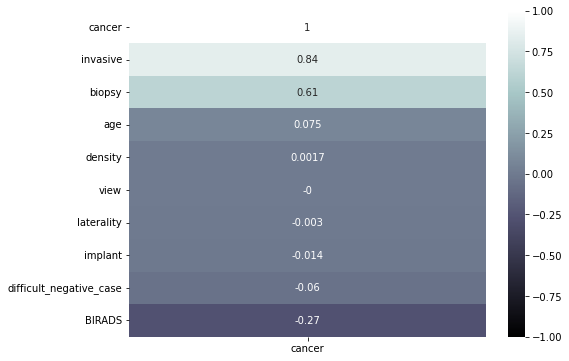

In [353]:
# Checking correlation 
plt.figure(figsize=(8, 6))
sns.heatmap(no_duplicate_df.drop(columns=['site_id', 'patient_id', 'image_id']).corr()[['cancer']].sort_values(by='cancer', ascending=False).round(5), vmin=-1, vmax=1, cmap='bone',annot=True)

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3666584760.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(no_duplicate_df.drop(columns=['site_id', 'patient_id', 'image_id','biopsy', 'invasive', 'BIRADS', 'difficult_negative_case']).corr().round(5), vmin=-1, vmax=1, cmap='bone',annot=True)


<AxesSubplot: >

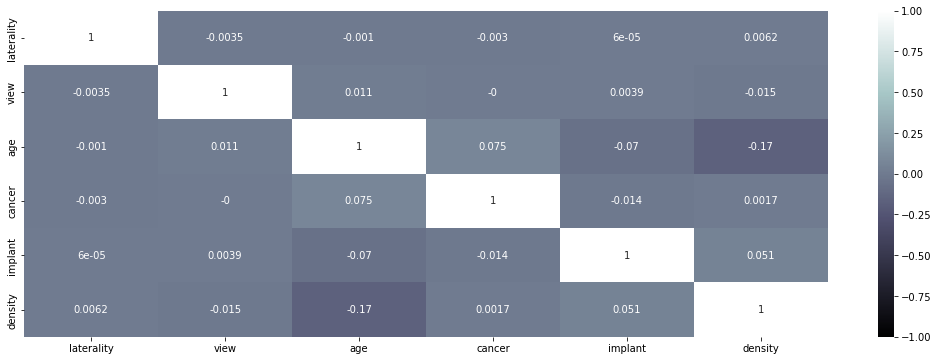

In [354]:
# Checking correlation for all
plt.figure(figsize=(18, 6))
sns.heatmap(no_duplicate_df.drop(columns=['site_id', 'patient_id', 'image_id','biopsy', 'invasive', 'BIRADS', 'difficult_negative_case']).corr().round(5), vmin=-1, vmax=1, cmap='bone',annot=True)

In [355]:
def custom_plot(df, title, y_label, x_label, legend, yticklabels, y, x, hue, custom_color, binwidth, alpha):
  fig, ax = plt.subplots(figsize=(8, 6))
  ax = sns.histplot(data=df, y=y, x=x, hue=hue, palette=custom_color, ax=ax , binwidth=binwidth, alpha=alpha)
  ax.set_title(label=title, fontsize=32)
  ax.set_yticklabels(ax.get_yticklabels() if yticklabels == 'self' else yticklabels, fontsize=15)
  ax.set_ylabel(y_label)
  ax.set_xlabel(x_label, fontsize=25)
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
  ax.legend(labels=legend)
  plt.show();

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3789414907.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


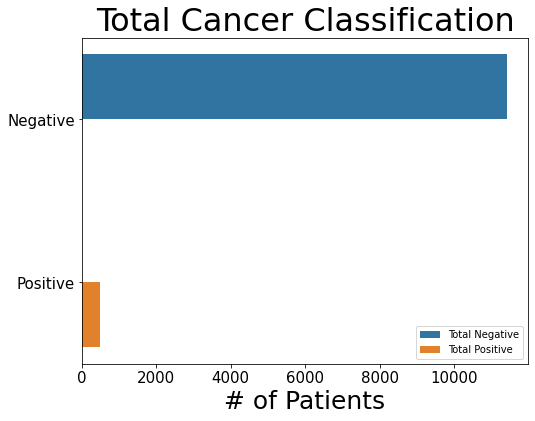

In [356]:
# Get unique patients dataframe
unique_patients_df = no_duplicate_df.drop_duplicates(subset='patient_id')

# 
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(data=unique_patients_df, y='cancer', hue='cancer', ax=ax)
ax.set_title(label='Total Cancer Classification', fontsize=32)
ax.set_yticklabels(['Negative', 'Positive'], fontsize=15)
ax.set_ylabel(None)
ax.set_xlabel('# of Patients', fontsize=25)
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
ax.legend(labels=['Total Negative', 'Total Positive'])
plt.show();

- There are 11,905 patients
  - 486 Positive Cases
  - 11,419 Negative Cases

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels() if yticklabels == 'self' else yticklabels, fontsize=15)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


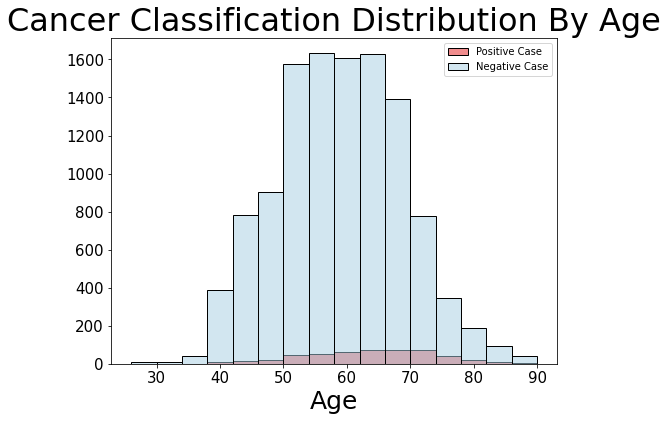

In [357]:
# Plot distribution of cancer
custom_color_palette = [sns.color_palette('Paired')[0], sns.color_palette('Paired')[5]]

custom_plot(
    unique_patients_df,
    title='Cancer Classification Distribution By Age',
    yticklabels='self',
    y_label=None,
    x_label="Age",
    legend=['Positive Case', 'Negative Case'],
    y=None,
    x='age',
    hue="cancer",
    custom_color=custom_color_palette,
    binwidth=4, 
    alpha=0.5,
)

> Patient's age is normally distributed

In [358]:
unique_patients_df[unique_patients_df['cancer'] == 1]['age'].var()
# Variance tells you the degree of spread in your data set. 
# The more spread the data, the larger the variance is in relation to the mean

97.52470408552884

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\2582536184.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(data=cancer_only_df, x='age', palette=sns.color_palette('Paired')[6:9], kde=True)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\2582536184.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=15)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\2582536184.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


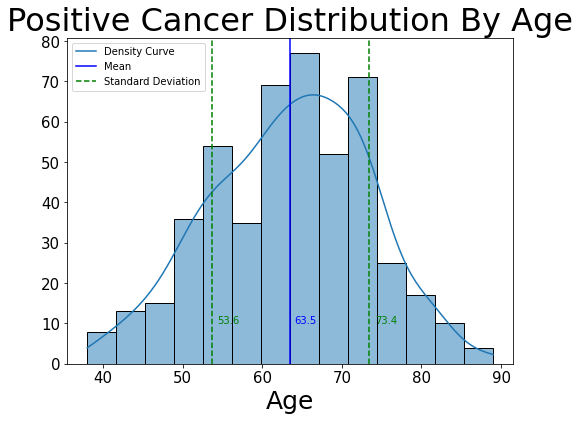

In [359]:
fig, ax = plt.subplots(figsize=(8, 6))
cancer_only_df = unique_patients_df[unique_patients_df['cancer'] == 1]
ax = sns.histplot(data=cancer_only_df, x='age', palette=sns.color_palette('Paired')[6:9], kde=True)
ax.set_title('Positive Cancer Distribution By Age', fontsize=32)
ax.set_ylabel(None)
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=15)
ax.set_xlabel('Age', fontsize=25)
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
ax.axvline(cancer_only_df['age'].mean(), color='blue')
ax.text(cancer_only_df['age'].mean()+0.5, 10, f"{cancer_only_df['age'].mean().round(1)}", color='blue')

ax.axvline(cancer_only_df['age'].mean() + cancer_only_df['age'].std(), color='green', ls='--')
ax.text((cancer_only_df['age'].mean() + cancer_only_df['age'].std()) + .8, 10, f"{(cancer_only_df['age'].mean() + cancer_only_df['age'].std()).round(1)}", color='green')

ax.axvline(cancer_only_df['age'].mean() - cancer_only_df['age'].std(), color='green', ls='--')
ax.text((cancer_only_df['age'].mean() - cancer_only_df['age'].std()) + .7, 10, f"{(cancer_only_df['age'].mean() - cancer_only_df['age'].std()).round(1)}", color='green')

ax.legend(['Density Curve', 'Mean', 'Standard Deviation'])
plt.show();

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.histplot(data=df, y=y, x=x, hue=hue, palette=custom_color, ax=ax , binwidth=binwidth, alpha=alpha)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels() if yticklabels == 'self' else yticklabels, fontsize=15)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


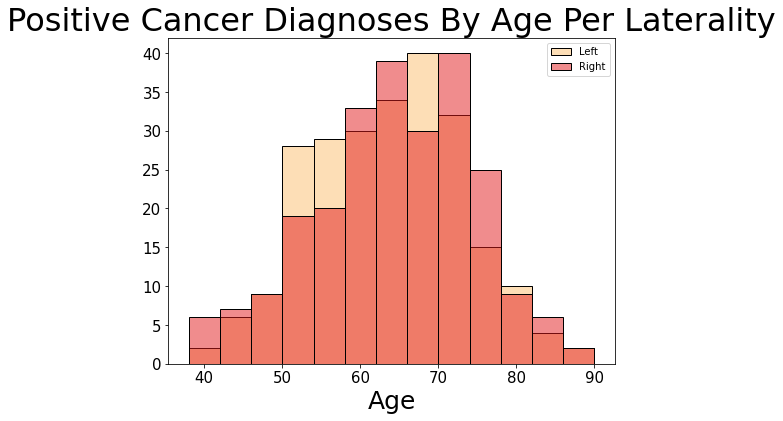

In [360]:
# Plot By Age Per Breast for positive cancer patients
custom_plot(
    cancer_only_df,
    title='Positive Cancer Diagnoses By Age Per Laterality',
    yticklabels='self',
    y_label=None,
    x_label="Age",
    legend=['Left', 'Right'],
    y=None,
    x='age',
    hue="laterality",
    custom_color=sns.color_palette('Paired')[5:9],
    binwidth=4, 
    alpha=0.5,
)

C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:3: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.histplot(data=df, y=y, x=x, hue=hue, palette=custom_color, ax=ax , binwidth=binwidth, alpha=alpha)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels() if yticklabels == 'self' else yticklabels, fontsize=15)
C:\Users\btoli\AppData\Local\Temp\ipykernel_15256\3187786108.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)


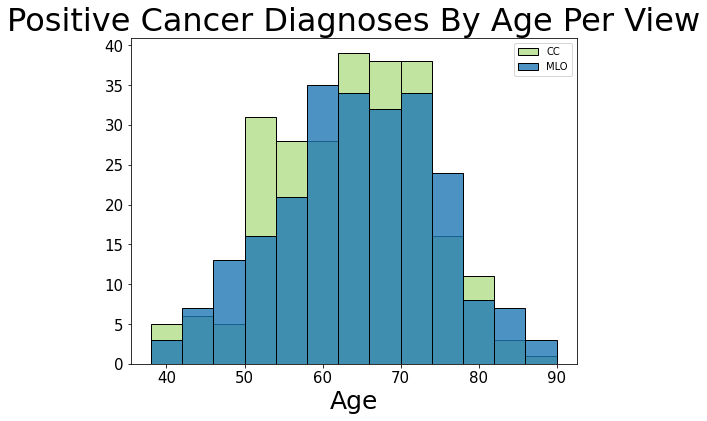

In [361]:
# Plot Age per view for positive cancer diagnoses
custom_plot(
    cancer_only_df,
    title='Positive Cancer Diagnoses By Age Per View',
    yticklabels='self',
    y_label=None,
    x_label="Age",
    legend=['CC', 'MLO'],
    y=None,
    x='age',
    hue="view",
    custom_color=sns.color_palette('Paired')[1:10],
    binwidth=4, 
    alpha=0.8,
)

## Mammograms

In [382]:
import os
from pydicom import dcmread

# plt.figure(figsize=(10, 6))
# for images, labels in train_ds.take(1):
#   for i in range(10):
#     l = random.randint(1,28)
#     ax = plt.subplot(2,5, i + 1)
#     plt.imshow(images[l].numpy().astype("uint8"))
#     plt.title(class_names[labels[l]])
#     plt.suptitle('Random Images',size = 20)
#     plt.axis('off')

def plot_mamm(item, title):
  ds = dcmread(f"../../data/train_images/{item['patient_id']}/{item['image_id']}.dcm")

  plt.figure(figsize=(15,10))
  plt.imshow(ds.pixel_array, cmap='bone')  # set the color map to bone
  plt.title(title, fontsize = 15)
  plt.axis('off')
  plt.show()

In [366]:
cancer_only_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,custom_id
18859,1,29919,1361547019,1,0,58.0,1,1,1,0,0,1,False,29919-R
51437,2,65492,1186509485,0,1,59.0,1,1,1,0,0,2,False,65492-L
4538,2,14941,303808170,1,1,68.0,1,1,1,0,0,2,False,14941-R
30132,1,42160,684267184,1,1,68.0,1,1,1,0,0,2,False,42160-R
41718,2,55095,864613243,1,0,75.0,1,1,1,0,0,2,False,55095-R


----
### Left - CC - Non Invasive - Density {check} - Not Difficult Case - Positive Cancer


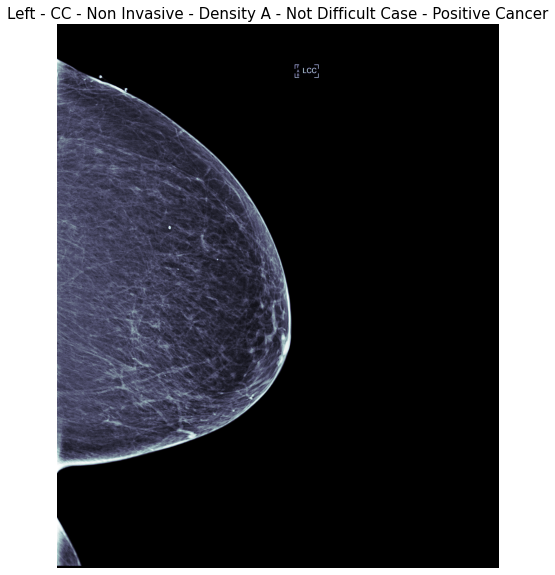

In [383]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 0) &
    (unique_patients_df["difficult_negative_case"] == 0) & (unique_patients_df["cancer"] == 1)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - CC - Non Invasive - Density A - Not Difficult Case - Positive Cancer")


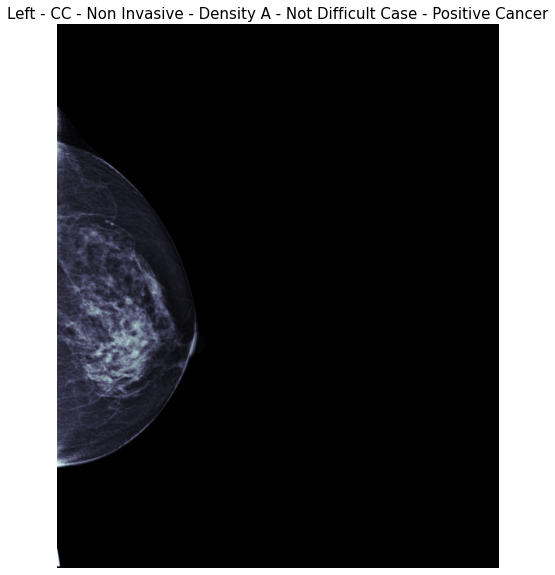

In [395]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 1) &
    (unique_patients_df["difficult_negative_case"] == 0) & (unique_patients_df["cancer"] == 1)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - CC - Non Invasive - Density B - Not Difficult Case - Positive Cancer")


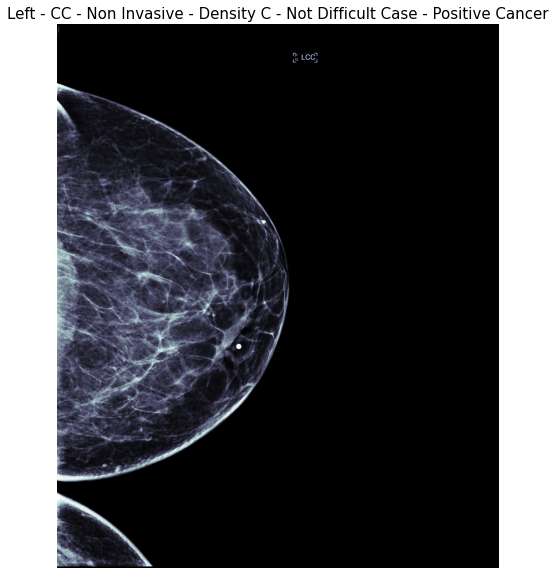

In [396]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 2) &
    (unique_patients_df["difficult_negative_case"] == 0) & (unique_patients_df["cancer"] == 1)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - CC - Non Invasive - Density C - Not Difficult Case - Positive Cancer")


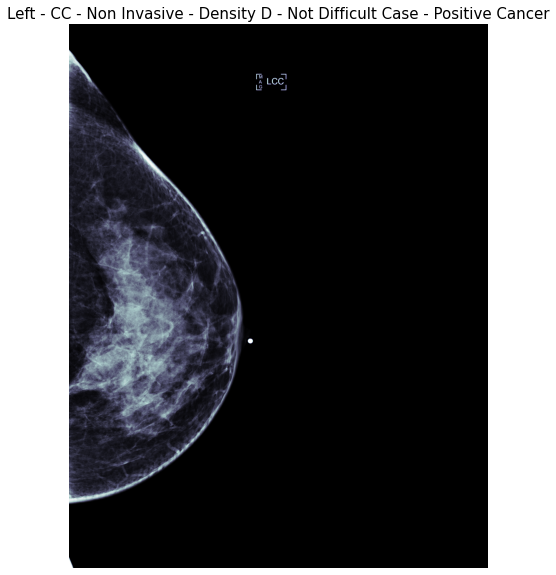

In [401]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 3) &
    (unique_patients_df["difficult_negative_case"] == 0) & (unique_patients_df["cancer"] == 1)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - CC - Non Invasive - Density D - Not Difficult Case - Positive Cancer")


----
### Left - CC - {Non Invasive} - Density B - Not Difficult Case - Positive Cancer

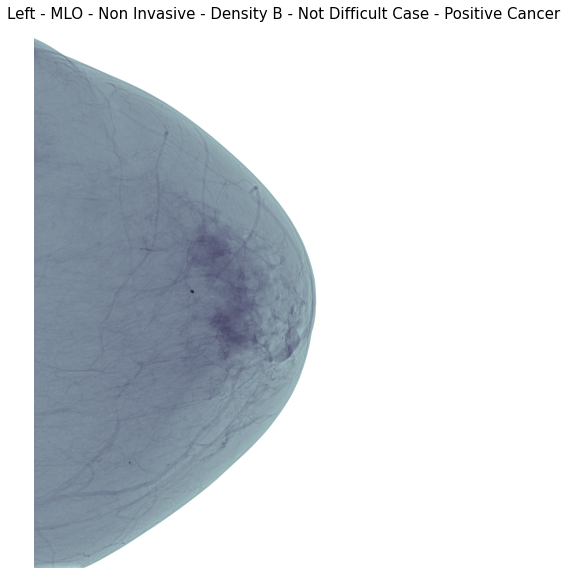

In [406]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 1) &
    (unique_patients_df["difficult_negative_case"] == 0) & (unique_patients_df["cancer"] == 1)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[2], title="Left - CC - Non Invasive - Density B - Not Difficult Case - Positive Cancer")


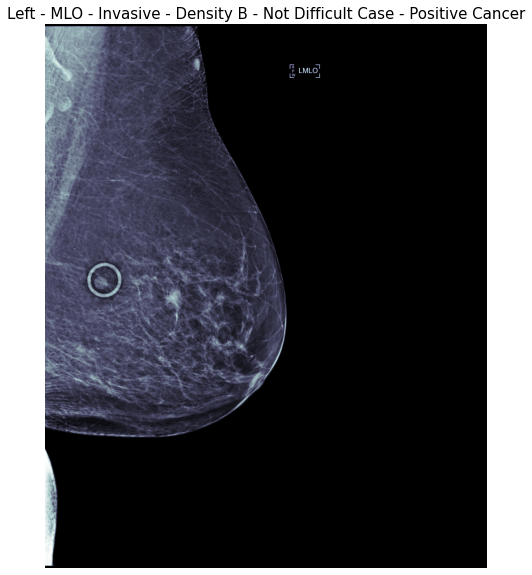

In [408]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 1) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 1) & (unique_patients_df["density"] == 1) &
    (unique_patients_df["difficult_negative_case"] == 0) & (unique_patients_df["cancer"] == 1)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - MLO - Invasive - Density B - Not Difficult Case - Positive Cancer")


----
Left - CC - Not Invasive - Density B - Difficult Case - Negative Cancer

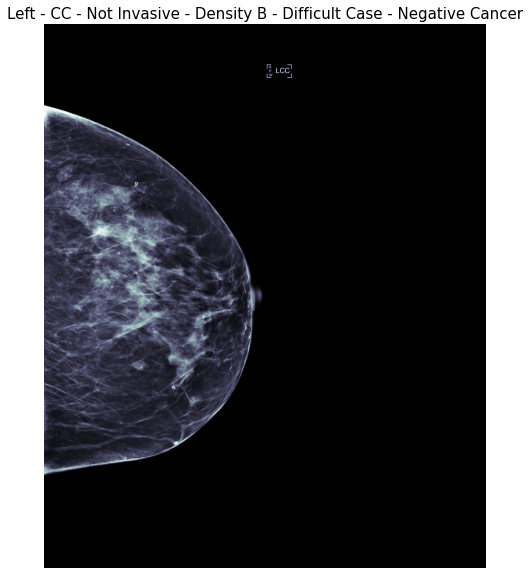

In [424]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 0) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 1) &
    (unique_patients_df["difficult_negative_case"] == True) & (unique_patients_df["cancer"] == 0)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - CC - Not Invasive - Density B - Difficult Case - Negative Cancer")


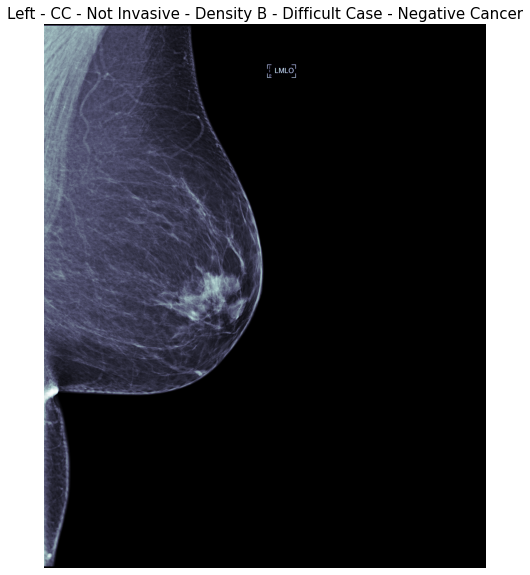

In [425]:
left_cc_invasive_density_difficult_cancer = unique_patients_df[
    (unique_patients_df["view"] == 1) & (unique_patients_df["laterality"] == 0) &
    (unique_patients_df["invasive"] == 0) & (unique_patients_df["density"] == 1) &
    (unique_patients_df["difficult_negative_case"] == True) & (unique_patients_df["cancer"] == 0)
]
plot_mamm(left_cc_invasive_density_difficult_cancer.iloc[0], title="Left - CC - Not Invasive - Density B - Difficult Case - Negative Cancer")
